In [ ]:
from ase.build import bulk

import numpy as np

import pyiron_workflow as pwf
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.bulk import eos_volume_scan, get_equil_lat_param, get_bulk_structure
from pyiron_workflow_atomistics.calculator import calculate_structure_node
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode
from pyiron_workflow_atomistics.calculator import ase_calculate_structure_node_interface

# from tensorpotential.calculator import TPCalculator
from pyiron_workflow import Workflow
from pyiron_workflow_lammps.calculator import lammps_calculator_node
from pyiron_workflow_atomistics.gb.dataclass_storage import PlotCleaveInput, CalcStructureInput, CleaveGBStructureInput
from pyiron_workflow_lammps.lammps import lammps_job, LammpsInput
from pyiron_workflow_lammps.calculator import lammps_calculator_node
import os

%load_ext autoreload
%autoreload 2

In [51]:
type(mid_atom)

ase.atom.Atom

In [ ]:
from ase.atom import Atom

In [57]:
import numpy as np
from ase import Atoms
from ase.atom import Atom
@pwf.as_function_node("atom")
def get_middle_atom(atoms: Atoms, axis: int | str = 2) -> Atom:
    """
    Return the index of the atom whose coordinate along the given axis
    is closest to the mid-plane of the cell.
    
    Parameters
    ----------
    atoms : ase.Atoms
        The supercell.
    axis : int or {'x','y','z'}, default=2
        Which axis to slice along. 0='x', 1='y', 2='z'.
    
    Returns
    -------
    idx : int
        Index of the atom closest to the center along that axis.
    """
    # allow strings 'x','y','z'
    if isinstance(axis, str):
        axis = {'x':0, 'y':1, 'z':2}[axis.lower()]
    
    # get fractional positions along axis (handles PBC nicely)
    scaled = atoms.get_scaled_positions()[:, axis]
    # the mid-plane in fractional coords is always 0.5
    target = 0.5
    # find atom nearest to that plane
    idx = int(np.argmin(np.abs(scaled - target)))
    return supercell[idx]

# --- Usage example ---
supercell = wf2.gb_seg_supercell.outputs["supercell"].value
mid_atom   = get_middle_atom.node_function(supercell, axis='z')

print(f"Middle atom along c: {mid_atom}")
print("Frac position:", mid_atom.scaled_position)
print("Cartesian position:", mid_atom.position)


Middle atom along c: Atom('Fe', [0.08534885305950458, 3.916365643815352e-09, 30.9273731905578], index=18)
Frac position: [1.16156148e-02 4.89592367e-10 5.09578135e-01]
Cartesian position: [8.53488531e-02 3.91636564e-09 3.09273732e+01]


In [55]:
wf.middle_atom.value.position[2]

30.9273731905578

/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_000' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_001' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_002' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_003' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev

0


/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.300' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_-0.200' already exists. Existing files may be overwritten.
  warnings.warn(


MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.868301137016324]) [-295.88621062222, -295.937077308428, -295.887434248476] [MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.36525758576234]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.86525758576234]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 42.36525758576234])] [41.36525758576234, 41.86525758576234, 42.36525758576234] -295.9370791705131


/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.050' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.025' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.000' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_-0.025' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/py

MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.854743609972786]) [-295.936832814262, -295.937073907783, -295.937062487993, -295.936800620839, -295.936290354886] [MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.81830113701633]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.843301137016326]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.868301137016324]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.89330113701632]), MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925629, 3.99961877, 41.91830113701632])] [41.81830113701633, 41.843301137016326, 41.868301137016324, 41.89330113701632, 41.91830113701632] -295.93709931730376


/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/' already exists. Existing files may be overwritten.
  warnings.warn(


FailedChildError: /gb_optimiser_whole_lammps encountered error in child: {'/gb_optimiser_whole_lammps/calc_cleavage_rigid.accumulate_and_run': FailedChildError('/gb_optimiser_whole_lammps/calc_cleavage_rigid encountered error in child: {\'/gb_optimiser_whole_lammps/calc_cleavage_rigid/cleave_setup.accumulate_and_run\': TypeError("unsupported operand type(s) for -: \'float\' and \'GetItem\'")}')}

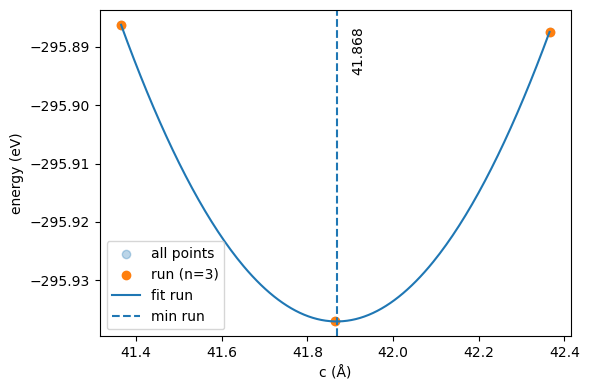

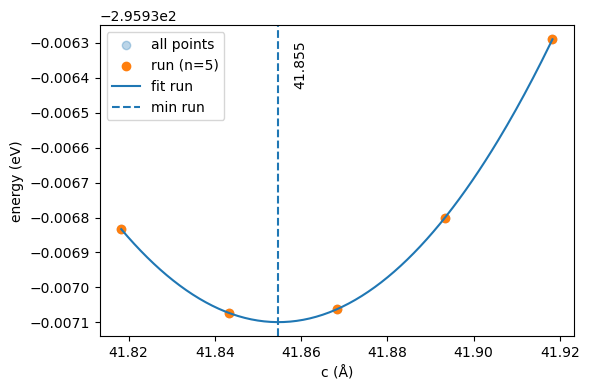

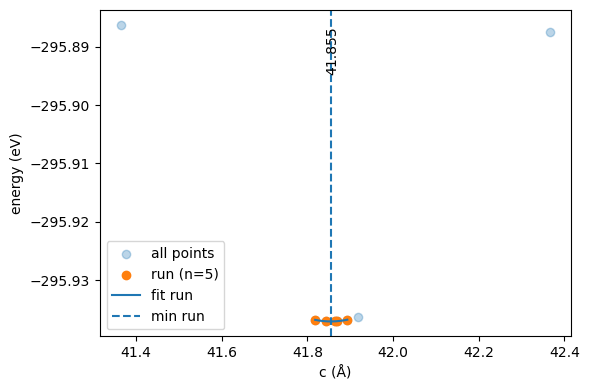

In [ ]:
# 1. Prepare calculator and workflow
import shutil

working_directory = "gb_optimiser_whole_lammps"
try:
    shutil.rmtree(working_directory, ignore_errors=True)
except:
    pass
wf   = Workflow(working_directory, delete_existing_savefiles=True)

# 2. Build your base Fe structure
bulk_Fe = bulk("Fe", cubic=True, a=2.83)
bulk_Fe.rattle()
working_directory = "/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/"
lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.0001,
    ftol=0.01,
    maxiter=1_000_000,
    maxeval=1_000_000,
)
potential_elements = ["Fe"]
lammps_calculator_input = {
    "working_directory": working_directory,
    "lmp_input": lmp_input,
    "potential_elements": potential_elements,
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

# 3. Attach the macro node to the workflow, capturing all outputs
wf.eos = eos_volume_scan(
    base_structure = bulk_Fe,
    calc_structure_fn = lammps_calculator_node,
    calc_structure_fn_kwargs = lammps_calculator_input,
    axes           = ["a", "b", "c"],
    strain_range   = (-0.02, 0.02),
    num_points     = 11,
)
wf.a0 = get_equil_lat_param(wf.eos.outputs.v0)
wf.eq_bulk_struct = get_bulk_structure(name = "Fe",
                           cubic = True,
                           a = wf.a0)

@pwf.as_function_node("per_atom_quantity")
def get_per_atom_quantity(quantity, structure):
    per_atom_quantity = quantity/len(structure)
    return per_atom_quantity
    
wf.equil_energy = get_per_atom_quantity(wf.eos.outputs.e0, wf.eq_bulk_struct.outputs.equil_struct)
wf.equil_volume = get_per_atom_quantity(wf.eos.outputs.v0, wf.eq_bulk_struct.outputs.equil_struct)

wf.gb_structure = construct_GB_from_GBCode(
    axis=(1, 1, 1),
    basis="bcc",
    lattice_param=wf.a0,
    m=3,
    n=1,
    GB1=(-1, -1, 2),
    element="Fe",
    req_length_grain=15,
    grain_length_axis=0,
    arrange_ab_by_length=True,
    perform_equiv_check=False,
    merge_dist_tolerance=1.3,
    merge_mode="average",
    equil_volume=wf.equil_volume
)
from pyiron_workflow_atomistics.gb.optimiser import full_gb_length_optimization
wf.gb_length_optimiser = full_gb_length_optimization(
    gb_structure=wf.gb_structure.outputs.final_structure,
    calc_structure_fn=lammps_calculator_node,
    calc_structure_fn_kwargs=lammps_calculator_input,
    equil_bulk_volume=wf.equil_volume,
    equil_bulk_energy=wf.equil_energy,
    extensions_stage1=np.linspace(-0.2, 0.8, 3),
    extensions_stage2=np.linspace(-0.05, 0.05, 5),
    interpolate_min_n_points=5,
    gb_normal_axis="c"
)
from pyiron_workflow_atomistics.gb.optimiser import gb_length_optimiser
from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum
wf.gb_with_vacuum = add_vacuum(wf.gb_length_optimiser.outputs.gb_structure_final,
                               vacuum_length = 20,
                               axis = "c")
wf.gb_with_vacuum_rel =  calculate_structure_node(
                                        structure = wf.gb_with_vacuum,
                                        calc_structure_fn=lammps_calculator_node,
                                        calc_structure_fn_kwargs=lammps_calculator_input,
                                        )
from pyiron_workflow_atomistics.structure_manipulator.tools import create_supercell_with_min_dimensions

wf.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms, 
                                                           min_dimensions=[6, 6, None])

from pyiron_workflow_atomistics.gb.cleavage import calc_cleavage_GB
wf.middle_atom = get_middle_atom(atoms = wf.gb_seg_supercell, axis = 2)
@pwf.as_function_node("CleaveGBStructureInput")
def get_CleaveGBStructureInput(middle_atom,
                               axis_to_cleave="c",
                                tol=0.3,
                                cleave_region_halflength=5.0,
                                layer_tolerance=0.3,
                                separation=8.0,
                                use_fractional=False):
    return CleaveGBStructureInput(axis_to_cleave=axis_to_cleave,
                                  tol=tol,
                                  cleave_region_halflength=cleave_region_halflength,
                                  layer_tolerance=layer_tolerance,
                                  separation=separation,
                                  use_fractional=use_fractional,
                                  cleavage_target_coord=middle_atom.position[2])
wf4.CleaveGBStructureInput = get_CleaveGBStructureInput(middle_atom=wf4.middle_atom.outputs.atom)
wf.CleaveGBStructureInput = CleaveGBStructureInput(axis_to_cleave="c",
                                                     tol=0.3,
                                                    cleave_region_halflength=5.0,
                                                    layer_tolerance=0.3,
                                                    separation=8.0,
                                                    use_fractional=False,
                                                    cleavage_target_coord=wf.middle_atom.outputs.atom)
wf.calc_cleavage_rigid = calc_cleavage_GB(structure=wf.gb_seg_supercell,
                                        energy = wf.gb_with_vacuum_rel.outputs.results["energy"],
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_directory,
                                        input_cleave_gb_structure = wf.CleaveGBStructureInput,
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
wf.run()
print(wf.middle_atom.outputs.atom.position[2])


{'calc_cleavage_rigid__cleaved_structure_list': [Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760032e-16, 4.499210813760032e-16], [0.0, 7.99923754, 4.898120324490174e-16], [0.0, 0.0, 60.692111840791384]]),
  Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760032e-16, 4.499210813760032e-16], [0.0, 7.99923754, 4.898120324490174e-16], [0.0, 0.0, 60.692111840791384]]),
  Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760032e-16, 4.499210813760032e-16], [0.0, 7.99923754, 4.898120324490174e-16], [0.0, 0.0, 60.692111840791384]]),
  Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760032e-16, 4.499210813760032e-16], [0.0, 7.99923754, 4.898120324490174e-16], [0.0, 0.0, 60.692111840791384]]),
  Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760032e-16, 4.499210813760032e-16], [0.0, 7.99923754, 4.898120324490174e-16], [0.0, 0.0, 60.692111840791384]]),
  Atoms(symbols='Fe216', pbc=True, cell=[[7.34776887, 4.499210813760

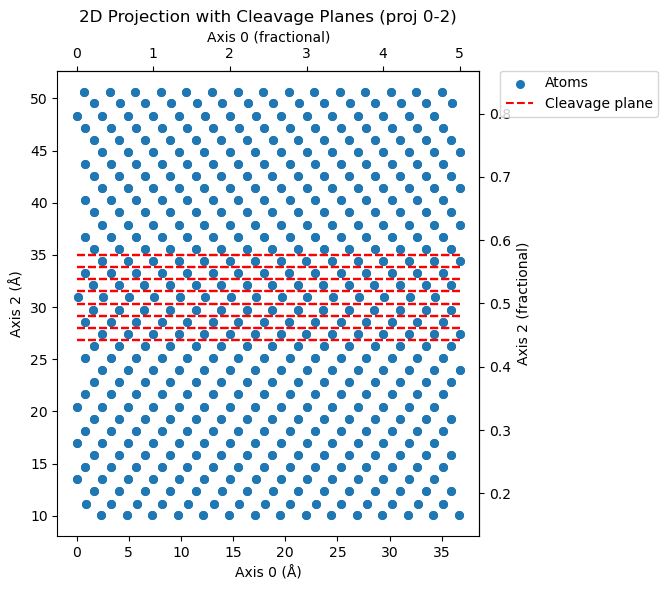

In [ ]:
wf4 = Workflow("gb_cleavage_testDataclass")
wf4.middle_atom = get_middle_atom(atoms = wf.gb_seg_supercell.outputs.supercell.value, axis = 2)
@pwf.as_function_node("CleaveGBStructureInput")
def get_CleaveGBStructureInput(middle_atom,
                               axis_to_cleave="c",
                                tol=0.3,
                                cleave_region_halflength=5.0,
                                layer_tolerance=0.3,
                                separation=8.0,
                                use_fractional=False):
    return CleaveGBStructureInput(axis_to_cleave=axis_to_cleave,
                                  tol=tol,
                                  cleave_region_halflength=cleave_region_halflength,
                                  layer_tolerance=layer_tolerance,
                                  separation=separation,
                                  use_fractional=use_fractional,
                                  cleavage_target_coord=middle_atom.position[2])
wf4.CleaveGBStructureInput = get_CleaveGBStructureInput(middle_atom=wf4.middle_atom.outputs.atom)

wf4.calc_cleavage_rigid = calc_cleavage_GB(structure=wf.gb_seg_supercell.outputs.supercell.value,
                                        energy = wf.gb_with_vacuum_rel.outputs.results.value["energy"],
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_directory,
                                        input_cleave_gb_structure = wf4.CleaveGBStructureInput.outputs.CleaveGBStructureInput,
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
wf4.run()

In [61]:
wf.middle_atom.outputs.atom.value.position[2]

30.9273731905578

/root/github_dev/pyiron_workflow_atomistics/notebooks
double peak detected
3 5


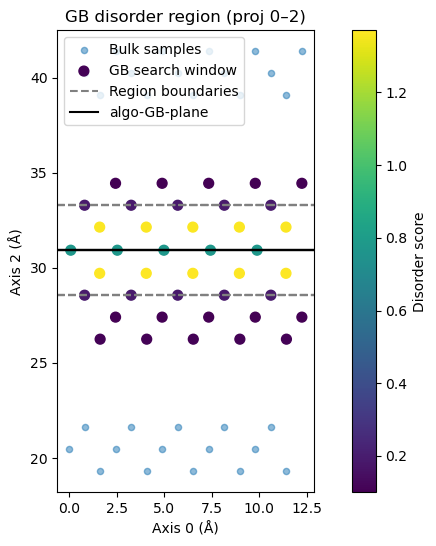

/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_21
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_20
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_19
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_18
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_17
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_16
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_15
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_14


{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>,
 'gb_seg_calcs__output_df':                                            structure  \
 0  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 1  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 2  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 3  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 4  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 5  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 6  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 7  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 
                             calc_structure_fn_kwargs  \
 0  {'lmp_input': units metal
 dimension 3
 boundary...   
 1  {'lmp_input': units metal
 dimension 3
 boundary...   
 2  {'lmp_input': units metal
 dimension 3
 boundary...   
 3  {'lmp_input': unit

In [ ]:

import shutil
import os
# os.chdir("/root/github_dev/test_workflow_nodes")
print(os.getcwd())
try:
    shutil.rmtree("gb_seg_lammps", ignore_errors=True)
    # Remove the entire tree and any files recursively
except:
    pass
wf2 = Workflow("gb_seg_lammps", delete_existing_savefiles=True)
wf2.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms.value, 
                                                           min_dimensions=[6, 6, None])

from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
from pyiron_workflow_atomistics.gb.analysis import plot_GB_plane, find_GB_plane
wf2.gb_plane_extractor = find_GB_plane(atoms = wf.gb_with_vacuum_rel.outputs.atoms.value,
                                        featuriser = voronoiSiteFeaturiser,
                                        axis = "c",
                                        approx_frac = 0.5,
                                        tolerance = 5.0,
                                        bulk_offset = 10.0,
                                        slab_thickness = 2.0,
                                        featuriser_kwargs = {},
                                        n_bulk = 10,
                                        threshold_frac = 0.3
                                      )
wf2.gb_plane_extractor_plot = plot_GB_plane(atoms = wf.gb_with_vacuum_rel.outputs.atoms.value,
                                            res = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict,
                                            projection=(0, 2),
                                            reps=(5, 1),
                                            figsize=(10, 6),
                                            bulk_color='C0',
                                            window_cmap='viridis',
                                            plane_linestyles=('--', '-'),
                                            axis=2,
                                            dpi=300,
                                            working_directory = "gb_seg_lammps",
                                            save_filename = f"pureGB_plane_identifier.jpg")

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.0001,
    ftol=0.01,
    maxiter=1_000_000,
    maxeval=1_000_000,
)
lammps_calculator_input = {
    "working_directory": "gb_seg_lammps",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

from pyiron_workflow_atomistics.gb.segregation import calculate_segregation_GB
from pyiron_workflow_lammps.lammps import lammps_job, LammpsInput
from pyiron_workflow_lammps.calculator import lammps_calculator_node
wf2.gb_seg_calcs = calculate_segregation_GB(
    structure = wf2.gb_seg_supercell,
    defect_sites = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"],
    element = "C",
    structure_basename = "S3_RA110_S112",
    parent_dir = "gb_seg_lammps",
    calc_kwargs = lammps_calculator_input,
    calc_structure_fn = lammps_calculator_node
)
wf2.run()

In [5]:
wf2.gb_seg_calcs.outputs.output_df.value.atoms.iloc[0]

Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]])

/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_30.296' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_29.068' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_27.898' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_26.791' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_clea

{'calc_cleavage_rigid__cleaved_structure_list': [Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.6921

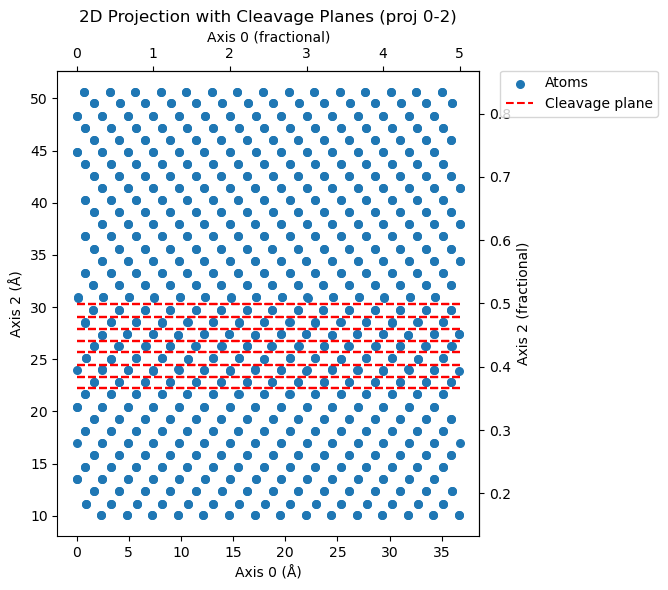

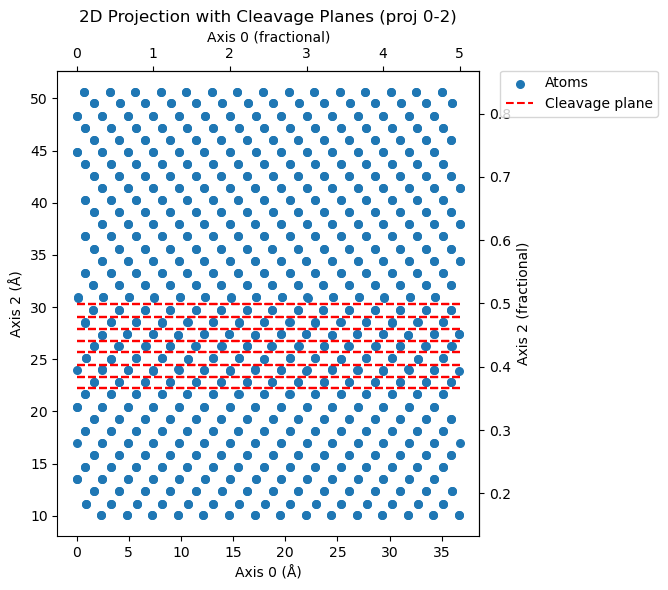

In [15]:
working_dir = "gb_cleavage_relax"

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    maxeval=200,
    maxiter=200,
    etol=0.0001,
    ftol=0.01,
)
lammps_calculator_input = {
    "working_directory": "gb_cleavage",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

def get_non_element_idx(structure, element):
    return [i for i, e in enumerate(structure.get_chemical_symbols()) if e != element]

wf3 = pwf.Workflow(working_dir)
gb_seg_structure = wf2.gb_seg_calcs.outputs.output_df.value.atoms.iloc[0]
non_fe_idx = get_non_element_idx(gb_seg_structure, "Fe")

energy = wf2.gb_seg_calcs.outputs.output_df.value.results.iloc[0]["energy"]
from pyiron_workflow_atomistics.gb.cleavage import calc_cleavage_GB
wf3.calc_cleavage_rigid = calc_cleavage_GB(structure=gb_seg_structure,
                                           energy = energy,
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_dir,
                                        input_cleave_gb_structure = CleaveGBStructureInput(cleavage_target_coord=gb_seg_structure[non_fe_idx[0]].position[2]),
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    maxeval=0,
    maxiter=0,
    etol=0.0001,
    ftol=0.01,
)
lammps_calculator_static_input = {
    "working_directory": "gb_cleavage_static",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}
wf3.calc_cleavage_relaxed = calc_cleavage_GB(structure=gb_seg_structure,
                                           energy = energy,
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_static_input,
                                        parent_dir = "gb_cleavage_static",
                                        input_cleave_gb_structure = CleaveGBStructureInput(cleavage_target_coord=gb_seg_structure[non_fe_idx[0]].position[2]),
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
wf3.run()



In [16]:
wf3.save()